## [Probabilistic Topic Modeling](http://pyro.ai/examples/prodlda.html#Probabilistic-Topic-Modeling)

#### Topic models are a suite of unsupervised learning algorithms that aim to discover and annotate large archives of documents with thematic information. Probabilistic topic models use statistical methods to analyze the words in each text to discover common themes, how those themes are connected to each other, and how they change over time. They enable us to organize and summarize electronic archives at a scale that would be impossible with human annotation alone. The most popular topic model is called latent Dirichlet allocation, or LDA.

![](https://i.ibb.co/zV5rjX6/Screen-Shot-2020-09-24-at-11-21-38.png)

##### We assume that there is a given number of “topics,” each of which is a probability distributions over words in the vocabulary (far left). Each document is assumed to be generated as follows: i) first, randomly choose a distribution over the topics (the histogram on the right); ii) then, for each word, randomly choose a topic assignment (the colored coins), and randomly choose the word from the corresponding topic. For an in-depth intuitive description, please check the excellent article from David Blei. The goal of topic modeling is to automatically discover the topics from a collection of documents. The documents themselves are observed, while the topic structure — the topics, per-document topic distributions, and the per-document per-word topic assignments — is hidden. The central computational problem for topic modeling is to use the observed documents to infer the hidden topic structure.

### [Pre-processing Data and Vectorizing Documents](http://pyro.ai/examples/prodlda.html#Pre-processing-Data-and-Vectorizing-Documents)

In [1]:
import os
import torch

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
news = fetch_20newsgroups(subset='all')

In [4]:
vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english') 
# Removing rare words (words that appear in less than 20 documents) and 
# common words (words that appear in more than 50% of the documents)

In [5]:
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())

In [6]:
docs.shape

torch.Size([18846, 12722])

In [7]:
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index

In [8]:
vocab.tail()

,word,index
12717,zoom,12717
12718,zuma,12718
12719,zurich,12719
12720,zx,12720
12721,zz,12721


##### We have a dictionary of 12,722 unique words and indices for each of them! And our corpus is comprised of almost 19,000 documents, where each row represents a document, and each column represents a word in the vocabulary. The data is the count of how many times each word occurs in that specific document. Now we are ready to move to the model.

### [Probabilistic Modeling and the Dirichlet distribution in Pyro](http://pyro.ai/examples/prodlda.html#Probabilistic-Modeling-and-the-Dirichlet-distribution-in-Pyro)

##### To understand how probabilistic modeling and Pyro work, let’s imagine a very simple example. Let’s say we have a dice and we want to determine whether it is loaded or fair. We cannot directly observe the dice’s ‘fairness’; we can only infer it by throwing the dice and observing the results. So, we throw it 30 times and observe the following results:

$$\mathcal{D} = \{5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, 3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6\}$$

$$p(\mathcal{D} | \theta) = \prod_{i = 1}^{6} \theta_{k}^{N_k}$$

In [9]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

In [10]:
def model(counts):
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
    total_count = int(counts.sum())
    pyro.sample('counts', dist.Multinomial(total_count, theta), obs=counts)

In [11]:
def model1(data):
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Categorical(theta), obs=data)

In [12]:
data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
                     3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])

counts = torch.unique(data, return_counts=True)[1].float()

In [13]:
nuts_kernel = NUTS(model1)
num_samples, warmup_steps = (1000, 200)

In [14]:
mcmc = MCMC(nuts_kernel, num_samples, warmup_steps)
mcmc.run(data -1)

Sample: 100%|██████████| 1200/1200 [00:15, 79.87it/s, step size=7.46e-01, acc. prob=0.898]


In [15]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [16]:
hmc_samples['theta'].mean(axis=0)

array([0.0839249 , 0.05520562, 0.27768153, 0.05442065, 0.41784552,
       0.11092154], dtype=float32)

In [17]:
hmc_samples['theta'].std(axis=0)

array([0.0470722 , 0.03890716, 0.07486459, 0.03836497, 0.08085248,
       0.04925879], dtype=float32)

### [LDA pseudocode, mathematical form, and graphical model](http://pyro.ai/examples/prodlda.html#LDA-pseudocode,-mathematical-form,-and-graphical-model)

![](https://i.ibb.co/3pyQfCV/Screen-Shot-2020-09-24-at-21-31-39.png)

$$
p(\theta, \mathbf{z}, \mathbf{w} | \alpha, \beta) = p(\theta | \alpha) \prod_{n=1}^{N} p(z_n | \theta) p(w_n | z_n, \beta)
$$

#### marginal distribution of a document d
$$
p(\mathbf{w} | \alpha, \beta) = \int_{\theta} \Bigg( \prod_{n=1}^{N} \sum_{z_n=1}^{k} p(w_n | z_n, \beta) p(z_n | \theta) \Bigg) p(\theta | \alpha) d\theta
$$

#### marginal distribution of a corpus D
$$p(\mathcal{D} | \alpha, \beta) = \prod_{d=1}^{M} \int_{\theta} \Bigg( \prod_{n=1}^{N_d} \sum_{z_{d,n}=1}^{k} p(w_{d,n} | z_{d,n}, \beta) p(z_{d,n} | \theta_d) \Bigg) p(\theta_d | \alpha) d\theta_d$$

![](https://i.ibb.co/jDGtP9Z/Screen-Shot-2020-09-25-at-12-33-35.png)

##### Each node is a random variable and is labeled according to its role in the generative process. The hidden nodes — the topic proportions, assignments, and topics — are unshaded. The observed nodes — the words of the documents — are shaded. The rectangles denote “plate” notation, which is used to encode replication of variables. The N plate denotes the collection of words within documents; the  M plate denotes the collection of documents within the collection.

##### Autoencoding variational Bayes (AEVB) is a particularly natural choice for topic models, because it trains an encoder network, a neural network that directly maps a document to an approximate posterior distribution, without the need to run further variational updates. However, despite some notable successes for latent Gaussian models, black box inference methods are significantly more challenging to apply to topic models. Two main challenges are: first, the Dirichlet prior is not a location scale family, which hinders reparameterization, and second, the well known problem of component collapse, in which the encoder network becomes stuck in a bad local optimum in which all topics are identical. (Note, however, that PyTorch/Pyro have included support for reparameterizable gradients for the Dirichlet distribution since 2018).

## [ProdLDA](http://pyro.ai/examples/prodlda.html#ProdLDA:-Latent-Dirichlet-Allocation-with-Product-of-Experts)

$$p(\theta | \alpha) \approx p(\theta | \mu, \Sigma) = \mathcal{LN}(\theta | \mu, \Sigma)$$

In [18]:
import math
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

In [19]:
from pyro.infer import SVI, TraceMeanField_ELBO

In [20]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden_size, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(vocab_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fcmu = nn.Linear(hidden_size, num_topics)
        self.fclv = nn.Linear(hidden_size, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False) # avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)

    def forward(self, input):
        h = F.softplus(self.fc1(input))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)

        logtheta_loc =self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))

        logtheta_scale = (0.5 * logtheta_logvar).exp() # positive constraint

        return logtheta_loc, logtheta_scale

In [21]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_topics, dropout) -> None:
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine= False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

In [22]:
class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hid_dim, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hid_dim, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module('decoder', self.decoder)
        with pyro.plate('documents', docs.shape[0]):
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                'logtheta',
                dist.Normal(logtheta_loc, logtheta_scale).to_event(1)
            )

            theta = F.softmax(logtheta, -1) # Dirichlet prior $p(\theta|\alpha)$
            
            count_param = self.decoder(theta)
            
            total_count = int(docs.sum(-1).max())

            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module('encoder', self.encoder)
        with pyro.plate('documents', docs.shape[0]):
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                'logtheta',
                dist.Normal(logtheta_loc, logtheta_scale).to_event(1)
            )

    def beta(self):
        return self.decoder.beta.weight.cpu().detach().T

In [23]:
seed = 11
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
num_topics = 20
docs = docs.float().to(device)
learning_rate = 1e-3
num_epochs = 100
batch_size =32

In [25]:
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics= num_topics,
    hid_dim= 50,
    dropout=0.2
)

prodLDA.to(device)

ProdLDA(
  (encoder): Encoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=12722, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
    (fcmu): Linear(in_features=50, out_features=20, bias=True)
    (fclv): Linear(in_features=50, out_features=20, bias=True)
    (bnmu): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): Decoder(
    (beta): Linear(in_features=20, out_features=12722, bias=False)
    (bn): BatchNorm1d(12722, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
)

In [26]:
optimizer = pyro.optim.Adam({'lr': learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss = TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size))

In [27]:
loc, scale = prodLDA.encoder(docs[0:2,:])

In [28]:
theta = pyro.sample('theta', dist.Normal(loc, scale).to_event(1))

In [29]:
bar = trange(num_epochs)

for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i*batch_size:(i+1)*batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

100%|██████████| 100/100 [21:36<00:00, 12.97s/it, epoch_loss=3.72e+05]


### [Visualize WordCloud](http://pyro.ai/examples/prodlda.html#WordClouds)

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [37]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab, how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100]*1000).int().numpy().tolist()
    freqs = {words[i]:sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color='White', width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n+1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')

In [38]:
beta = prodLDA.beta()

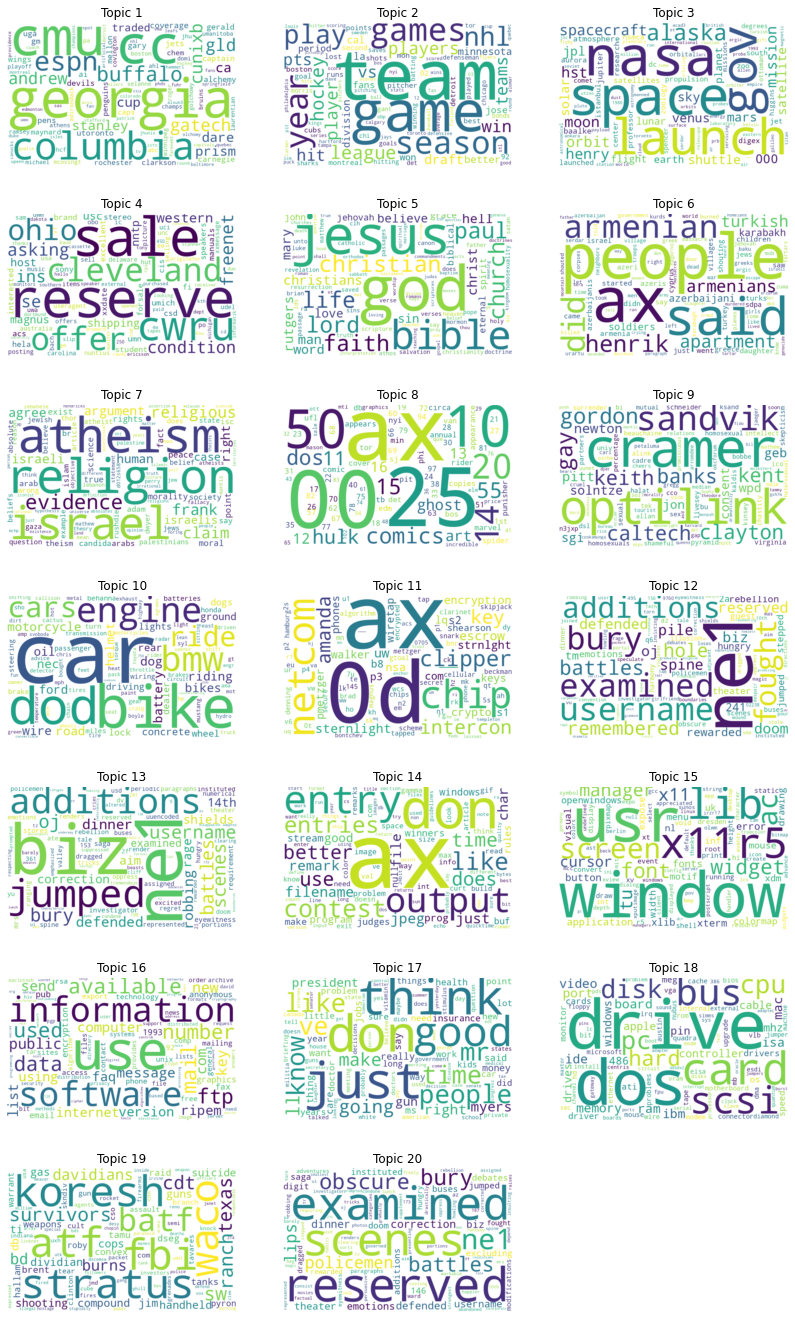

In [42]:
fig, axs = plt.subplots(7,3, figsize=(14,24))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(beta[n], axs[i,j], vocab, n)
axs[-1,-1].axis('off')
plt.show()